In [1]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, f1_score

df = pd.read_csv(r'E:\miniconda\ChineseSuperLeague\data\features.csv')
X = df[['home_last3_goals', 'away_last3_concede', 'home_last2_loss']].values
y = (df['result'] == 'H').astype(int).values

# 分层 + 标准化
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 转 Tensor
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test  = torch.tensor(X_test,  dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_test  = torch.tensor(y_test,  dtype=torch.float32).unsqueeze(1)

In [2]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(3, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 1)
        )
    def forward(self, x):
        return self.net(x)

model = MLP()
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
print(1)

1


In [3]:
epochs = 200
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    out = model(X_train)
    loss = criterion(out, y_train)
    loss.backward()
    optimizer.step()
    if (epoch+1) % 50 == 0:
        print(f'Epoch {epoch+1:3d} | Loss = {loss.item():.4f}')

Epoch  50 | Loss = 0.3905
Epoch 100 | Loss = 0.3638
Epoch 150 | Loss = 0.3528
Epoch 200 | Loss = 0.3395


In [21]:
# Cell 4：评估 + 阈值调优（已修复除零 & 支持全程调试）
import warnings, numpy as np
warnings.filterwarnings("ignore", category=RuntimeWarning)
model.eval()
with torch.no_grad():
    logits = model(X_test)
    probs = torch.sigmoid(logits).numpy()

# 1. 用 sklearn 一次性拿到 prec/rec/ths
from sklearn.metrics import precision_recall_curve, f1_score
prec, rec, ths = precision_recall_curve(y_test, probs)

# 2. 过滤除零：把 nan 变成 0，再找到最大 F1
f1s = np.where((prec + rec) == 0, 0, 2 * prec * rec / (prec + rec))
best_idx = np.argmax(f1s)
best_th = ths[best_idx]
print(f'最佳阈值={best_th:.2f} | 最大F1={f1s[best_idx]:.2f}')

# 3. 用最佳阈值重新预测并输出报告
y_pred = (probs >= best_th).astype(int)
print('\n'+classification_report(y_test, y_pred, target_names=['非主胜', '主胜']))

最佳阈值=0.30 | 最大F1=0.36

              precision    recall  f1-score   support

         非主胜       0.90      0.87      0.88        30
          主胜       0.33      0.40      0.36         5

    accuracy                           0.80        35
   macro avg       0.61      0.63      0.62        35
weighted avg       0.82      0.80      0.81        35



  0%|          | 0/35 [00:00<?, ?it/s]

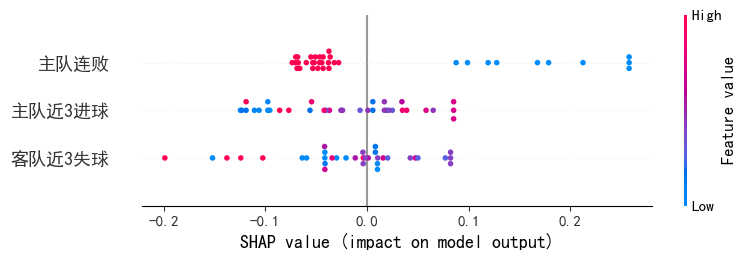

In [27]:
# Cell 5：SHAP 可解释性（KernelExplainer 版，无维度坑）
import shap, torch, numpy as np, matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'SimHei'
plt.rcParams['axes.unicode_minus'] = False

# 1. 数据统一 numpy
background = X_train[:50].numpy()
X_sub      = X_test[:50].numpy()

# 2. 模型包装：输出 numpy 概率
def model_prob(x):
    with torch.no_grad():
        return torch.sigmoid(model(torch.tensor(x, dtype=torch.float32))).numpy().squeeze(-1)  # (batch,)

# 3. SHAP
explainer   = shap.KernelExplainer(model_prob, background)
shap_values = explainer.shap_values(X_sub)   # (50, 3)

# 4. 画图
shap.summary_plot(
    shap_values,
    X_sub,
    feature_names=['主队近3进球', '客队近3失球', '主队连败']
)